In [ ]:
#hide
# Have to do this to avoid the performance degradation reported in https://forums.fast.ai/t/performance-degradation-between-fastai-2-2-5-and-2-2-7/86069
!pip install fastai==2.2.5

In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.PASCAL_2007)

In [4]:
def get_x(r): return (path/"train") / r["fname"]
def get_y(r): return r["labels"].split(" ")
def splitter(df):
  train = df.index[~df["is_valid"]].tolist()
  valid = df.index[df["is_valid"]].tolist()
  return train,valid
  
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                         get_x=get_x, 
                         get_y=get_y, 
                         splitter=splitter,
                         item_tfms= RandomResizedCrop(128, min_scale=0.35))

In [5]:
df = pd.read_csv(path / "train.csv")
dls = dblock.dataloaders(df)

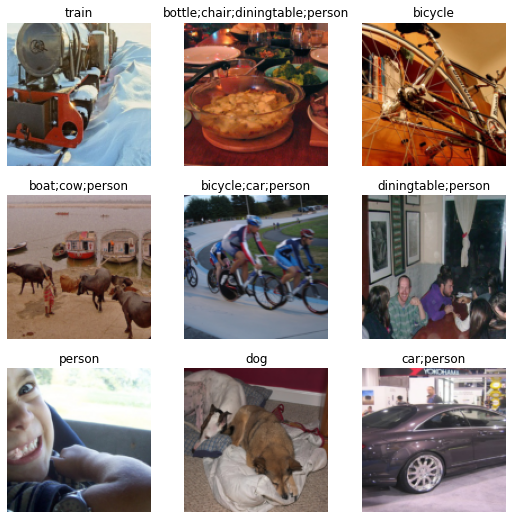

In [6]:
dls.show_batch()

In [8]:
dls.one_batch()[1].type()

'torch.cuda.FloatTensor'

## CNN Learner

This is pretty much exactly what is done in the book:

In [10]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy_multi])
learn.fine_tune(3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.980170,0.713133,0.599980,00:26
1,0.803975,0.443834,0.836016,00:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.493641,0.313083,0.920219,00:26
1,0.365913,0.197945,0.949880,00:26
2,0.289367,0.178912,0.952191,00:26


95% accuracy was great for the other datasets, but it doesn't really say much about how well we do in this problem. Even a model that just predicts 0 for every label (see below) gets 92% accuracy.

## Naive baseline

In [ ]:
class AllZeroModel(nn.Module):
    def __init__(self):
        super(AllZeroModel, self).__init__()

    def forward(self, x):
        output = torch.zeros(x.shape[0], 20).to("cuda:0")
        return output

In [ ]:
model = AllZeroModel()

In [ ]:
accuracy_no_sigmoid = partial(accuracy_multi, sigmoid=False)
dumb_learner = Learner(dls, AllZeroModel(), metrics=[accuracy_no_sigmoid])

In [ ]:
_, multi_accuracy = dumb_learner.validate()

In [ ]:
print(f"Multi Accuracy: {multi_accuracy}")

Multi Accuracy: 0.922390341758728


This shows that accuracy_multi is not an appropriate performance metric for this task. 

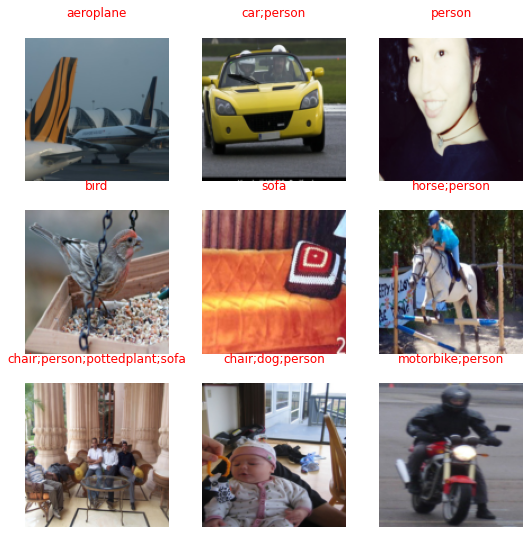

In [ ]:
dumb_learner.show_results()

## Attempt to use APScoreMulti

In [17]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi, APScoreMulti()])
learn.fine_tune(15, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,1.001838,0.769362,0.546634,0.173861,00:26
1,0.921729,0.663401,0.633825,0.460942,00:26
2,0.798754,0.492167,0.797052,0.565304,00:26
3,0.586803,0.219763,0.944721,0.588841,00:26
4,0.375911,0.141245,0.953028,0.640747,00:26


epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.161206,0.128997,0.955398,0.679767,00:26
1,0.149466,0.120250,0.957749,0.706428,00:26
2,0.134399,0.114865,0.959582,0.726883,00:26
3,0.120595,0.111866,0.959701,0.739273,00:26
4,0.109142,0.113648,0.960259,0.738980,00:26
5,0.096341,0.112842,0.959701,0.750272,00:26
6,0.084174,0.113031,0.959980,0.749608,00:26
7,0.072723,0.115655,0.960040,0.749519,00:26
8,0.062966,0.116411,0.960518,0.750506,00:26
9,0.054247,0.116021,0.960996,0.756028,00:26


Ahh, this makes more sense, SOTA is ~95% mAP ([source](https://arxiv.org/pdf/2009.14119.pdf)). Okay, I'm happy with this.

## GUI to interact with model

In [ ]:
from ipywidgets import FileUpload, Output, Label, VBox, Button

In [ ]:
upload = FileUpload()
out_pl = Output()
lbl_pred = Label()
btn_run = Button(description="classify")

def on_click_classify(change):
  img = PILImage.create(upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128, 128))
  pred, pred_idx, probs = learn.predict(tensor(img))
  lbl_pred.value = f'Prediction {pred}, Probability: {probs[pred_idx]}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([upload, btn_run, out_pl, lbl_pred])

In [ ]:
learn.predict(upload.data[-1])
print(pred)
print(list(zip(dls.vocab, probs)))